In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data=pd.read_csv("dm.csv")

In [4]:
data.head()

,Age,Gender,OwnHome,Married,Location,Salary,Children,History,Catalogs,AmountSpent,Cust_Id
0,Old,Female,Own,Single,Far,47500,0,High,6,755,247
1,Middle,Male,Rent,Single,Close,63600,0,High,6,1318,127
2,Young,Female,Rent,Single,Close,13500,0,Low,18,296,479
3,Middle,Male,Own,Married,Close,85600,1,High,18,2436,475
4,Middle,Female,Own,Single,Close,68400,0,High,12,1304,151


<AxesSubplot:title={'center':'AmountSpent'}, xlabel='Age'>

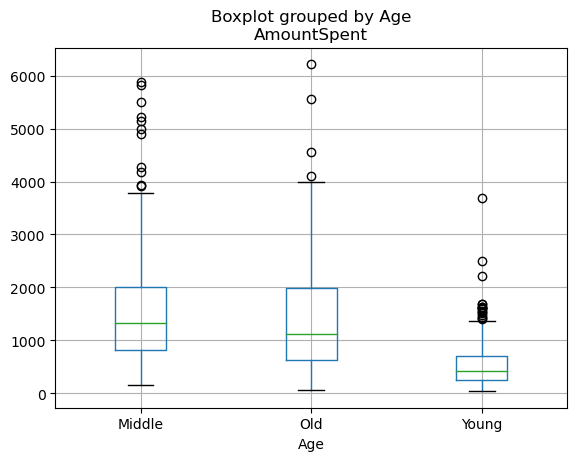

In [5]:
## Explore data
data.boxplot(by="Age",column="AmountSpent") ## Age has an impact on amount spent, spend behaviour of middle and old age people look the same

In [6]:
### Doing feature engineering on the age column
data["Age"]=data["Age"].map(lambda x: "Middle-Old" if x!="Young" else "Young")
data["Age"].unique()

array(['Middle-Old', 'Young'], dtype=object)

<AxesSubplot:title={'center':'AmountSpent'}, xlabel='Gender'>

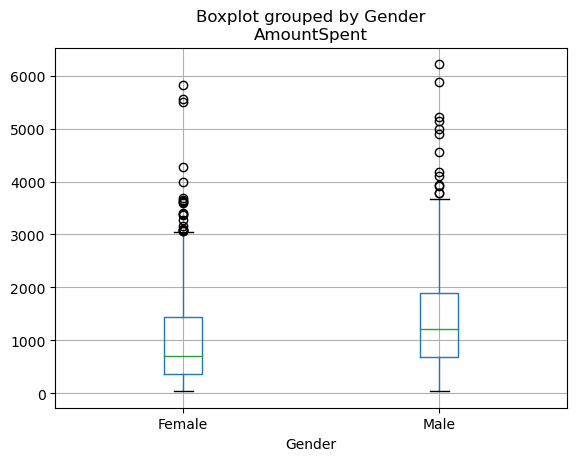

In [7]:
## Gender
data.boxplot(by="Gender",column="AmountSpent")

<AxesSubplot:title={'center':'AmountSpent'}, xlabel='OwnHome'>

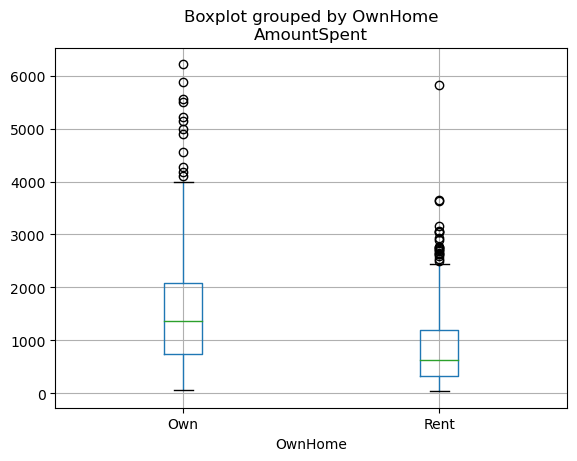

In [8]:
## Ownhome
data.boxplot(by="OwnHome",column="AmountSpent")

<AxesSubplot:title={'center':'AmountSpent'}, xlabel='Married'>

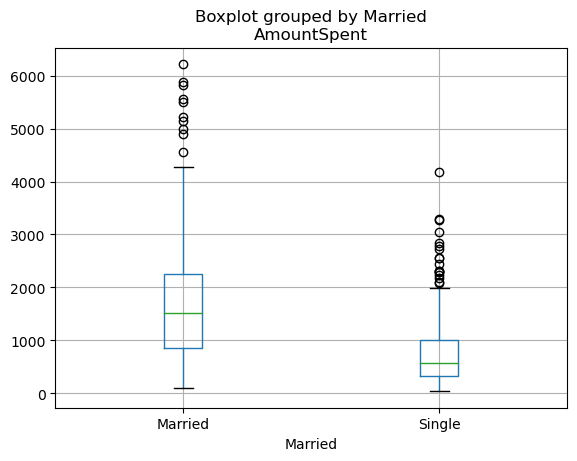

In [9]:
## Marital Status
data.boxplot(by="Married",column="AmountSpent")

In [10]:
data["History"].isnull().sum() ## Missing values in purchase history column, these are new customers

303

In [11]:
data["History"].fillna("NewCustomer",inplace=True)
data["History"].unique()

array(['High', 'Low', 'Medium', 'NewCustomer'], dtype=object)

<AxesSubplot:title={'center':'AmountSpent'}, xlabel='Children'>

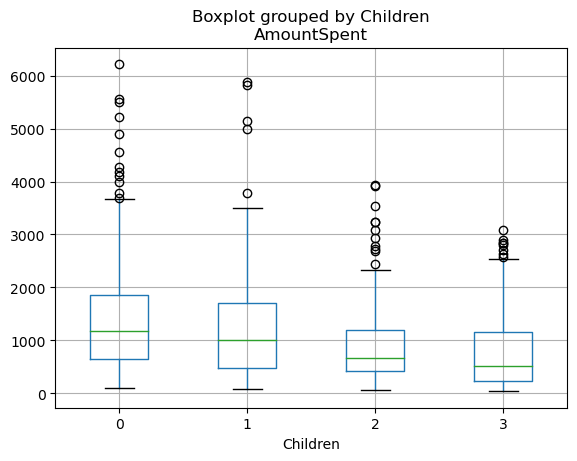

In [12]:
## Children
data.boxplot(by="Children",column="AmountSpent") ## 0 and 1 have similar spending behaviour, 2 and 3 also have a similar spending behaviour

In [13]:
## feature engineering on the Children variable
data["Children"]=data["Children"].map(lambda x: "0-1" if x<=1 else "2-3")

In [14]:
### Train test split
train=data.sample(frac=0.7,random_state=200)
test=data.drop(train.index)

In [15]:
import statsmodels.formula.api as smf
from patsy import dmatrices

In [21]:
model1=smf.ols('''AmountSpent~C(Age)+C(Gender)+C(OwnHome)+C(Married)+
                 C(Location)+Salary+Children+C(History)+Catalogs''',data=train).fit()

In [22]:
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:            AmountSpent   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     187.8
Date:                Thu, 23 Feb 2023   Prob (F-statistic):          9.16e-199
Time:                        12:08:22   Log-Likelihood:                -5324.6
No. Observations:                 700   AIC:                         1.067e+04
Df Residuals:                     688   BIC:                         1.073e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [23]:
## Remove the non significant variables from the model, we will need to create dummies for that
## create dummies
train["Low"]=train["History"].map(lambda x: 1 if x=="Low" else 0)
test["Low"]=test["History"].map(lambda x: 1 if x=="Low" else 0)
train["Medium"]=train["History"].map(lambda x: 1 if x=="Medium" else 0)
test["Medium"]=test["History"].map(lambda x: 1 if x=="Medium" else 0)

In [24]:
formula="AmountSpent~Salary+C(Children)+Low+Medium+C(Location)+Catalogs"
model2=smf.ols(formula,data=train).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:            AmountSpent   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     344.0
Date:                Thu, 23 Feb 2023   Prob (F-statistic):          5.39e-204
Time:                        12:09:41   Log-Likelihood:                -5326.6
No. Observations:                 700   AIC:                         1.067e+04
Df Residuals:                     693   BIC:                         1.070e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -274.3651     68

In [25]:
### Model Assumption checks
## Normality of residuals check

(array([ 27., 136., 241., 217.,  49.,  17.,   7.,   1.,   4.,   1.]),
 array([-1165.0324759 ,  -756.06326003,  -347.09404416,    61.8751717 ,
          470.84438757,   879.81360344,  1288.78281931,  1697.75203518,
         2106.72125104,  2515.69046691,  2924.65968278]),
 <BarContainer object of 10 artists>)

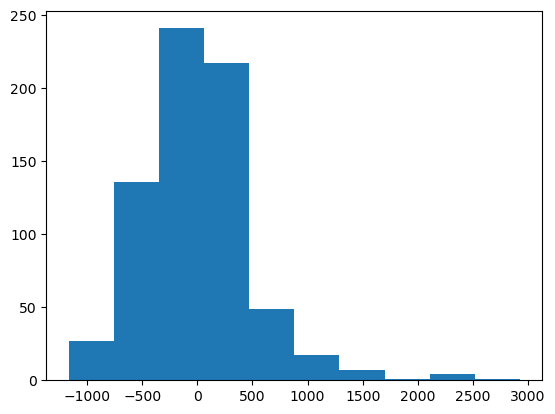

In [26]:
residuals=model2.resid
plt.hist(residuals) ## centered at zero, looks mostly symmetrical

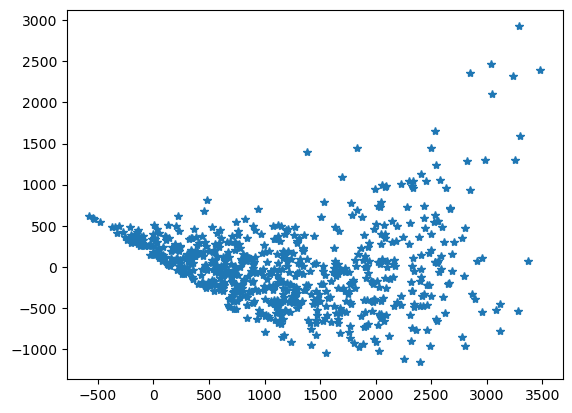

In [27]:
### Non constant variation check
fitted=model2.fittedvalues
plt.plot(fitted,residuals,"*") ## Non constant variation detected, need to corrected for

In [30]:
### Check VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
y,X=dmatrices(formula,data=train,return_type="dataframe")
vif=pd.DataFrame()
vif['VIF VALUES']=[variance_inflation_factor(X.values,i) for i in np.arange(0,X.shape[1])]
vif["Feature Name"]=X.columns
vif

,VIF VALUES,Feature Name
0,13.637747,Intercept
1,1.135407,C(Children)[T.2-3]
2,1.055400,C(Location)[T.Far]
3,1.347559,Salary
4,1.639647,Low
5,1.174494,Medium
6,1.056856,Catalogs


In [31]:
### VIF for all variables is less than 5 so there is no issue of multicollinearity

In [32]:
model3=smf.ols("np.log(AmountSpent)~Salary+C(Children)+Low+Medium+C(Location)+Catalogs",data=train).fit()

In [35]:
print(model3.summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(AmountSpent)   R-squared:                       0.839
Model:                             OLS   Adj. R-squared:                  0.838
Method:                  Least Squares   F-statistic:                     602.1
Date:                 Thu, 23 Feb 2023   Prob (F-statistic):          5.62e-271
Time:                         12:20:32   Log-Likelihood:                -259.93
No. Observations:                  700   AIC:                             533.9
Df Residuals:                      693   BIC:                             565.7
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.5

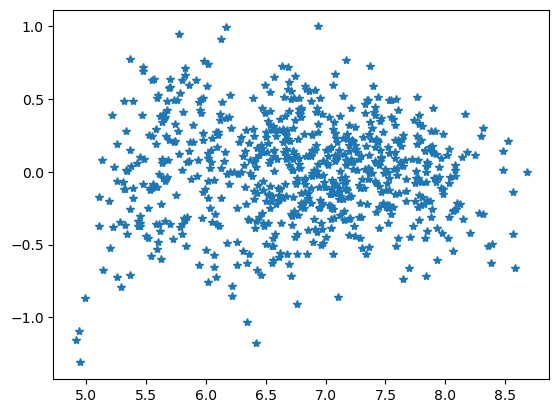

In [36]:
plt.plot(model3.fittedvalues,model3.resid,"*") ## Non constant variation problem removed!

In [37]:
### Final model coefficient interpretation
model3.params

Intercept             5.568378
C(Children)[T.2-3]   -0.386804
C(Location)[T.Far]    0.295889
Salary                0.000015
Low                  -0.696315
Medium               -0.164749
Catalogs              0.038363
dtype: float64

In [ ]:
## Amount spent increases as salary increases
## People who are sent more catalogs tend to spend more
## People who live far away from the stores of the competitors spend more C(Location)[T.Far]
## Poeple with low and medium purchase history spend less than people with High purchase history or new customers
##  People with 2-3 children spend less that people with 0-1 children